# Neural Network for MNIST dataset of digit recognition

Tutorial: https://www.geeksforgeeks.org/handwritten-digit-recognition-using-neural-network/

-   Uses scipy.optimize.minimize to run the gradient descent algorithm
-   Range of 1st & 2nd order algorithms to choose from
-   Selected: L-BFGS-B

In [1]:
from scipy.io import loadmat
import numpy as np
from scipy.optimize import minimize
from tkinter import *
from PIL import ImageGrab
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [2]:
# HYPERPARAMETERS
normalisation_factor = 1/255        # Each pixel = 8-bit integer (0-255)
input_layer_size = 28 * 28          # Number of features (pixels)
hidden_layer_size = 100             # Number of hidden units
num_labels = 10                     # Number of labels (0-9)
maxiter = 100                       # Maximum number of iterations for optimisation
lambda_reg = 0.1                    # Regularisation parameter (prevents overfitting)
epsilon = 0.15                      # Random initialisation parameter (prevents symmetry)

In [3]:
# Load mat file of data
data = loadmat('../../data/mnist-original.mat')
print("Keys: ", data.keys())
print("Dataset shape: ", data['data'].shape)

Keys:  dict_keys(['__header__', '__version__', '__globals__', 'mldata_descr_ordering', 'data', 'label'])
Dataset shape:  (784, 70000)


In [4]:
# Extract features and transpose
X = data['data'].T

# Normalise the data so that each pixel is in the range [0, 1]
X = X * normalisation_factor

# Extract labels from data and flatten
y = data['label'].flatten()

print("Data, X:\n ", X, "\n", X.shape)
print("\nLabels, y:\n ", y, "\n", y.shape)

Data, X:
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
 (70000, 784)

Labels, y:
  [0. 0. 0. ... 9. 9. 9.] 
 (70000,)


In [5]:
# Split data into training set with 60,000 samples and test set with 10,000 samples (capital for matrix, lower case for vector)
X_train = X[:60000, :]
y_train = y[:60000]
print("Training size: ", X_train.shape, y_train.shape)

# (2nd colon specifies all columns)
X_test = X[60000:, :]
y_test = y[60000:]
print("Testing size: ", X_test.shape, y_test.shape)

Training size:  (60000, 784) (60000,)
Testing size:  (10000, 784) (10000,)


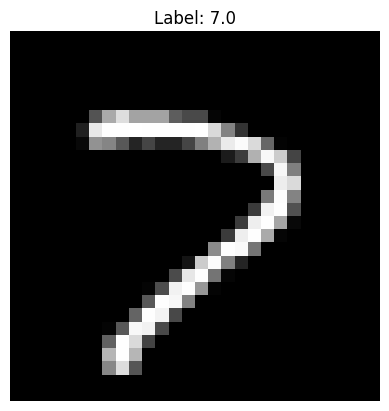

In [6]:
# Display a sample image (random by default)
def show_image(X, y, index=None):
    # Choose a random index if none is provided
    if index is None:
        N = X.shape[0]
        index = np.random.randint(0, N - 1)
    
    # Extract image data and label
    image = X[index].reshape(28, 28)
    label = y[index]
    
    # Display image and label
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()
    
# Choose a random index from the total number of images
show_image(X, y)

In [7]:
# Function to randomly initialise Thetas (weights) between a range of [-epsilon, epsilon]
def initialise(a, b, epsilon):
    # Scale and shift random values to be within range
    c = (np.random.rand(a, b + 1) * (2 * epsilon)) - epsilon
    
    # Returns matrix of randomly initialised weights, of dimensions a x (b + 1)
    return c

# epsilon chosen arbitrarily (small enough to avoid saturation and large enough to avoid vanishing gradients)
initial_Theta1 = initialise(hidden_layer_size, input_layer_size, epsilon)
initial_Theta2 = initialise(num_labels, hidden_layer_size, epsilon)
print("Theta1:\n ", initial_Theta1, "\n", initial_Theta1.shape)
print("\nTheta2:\n ", initial_Theta2, "\n", initial_Theta2.shape)

Theta1:
  [[ 0.00147816 -0.07189083  0.05506175 ... -0.04538693 -0.11448438
  -0.05962421]
 [ 0.10753582  0.0695507  -0.0304258  ...  0.01657934  0.10571481
   0.01543542]
 [ 0.02276993  0.02959162 -0.05387712 ...  0.03628767 -0.04921695
   0.12018984]
 ...
 [-0.08843389 -0.1109085  -0.09672597 ...  0.02214201 -0.04475138
  -0.02823986]
 [ 0.06964819  0.07849311  0.04547372 ...  0.00928075  0.13820973
   0.0454576 ]
 [ 0.00174491 -0.13453267  0.03649125 ... -0.0171884  -0.06542016
  -0.01408504]] 
 (100, 785)

Theta2:
  [[ 0.0122632   0.03775455 -0.02392025 ... -0.14111254  0.11653878
   0.06593465]
 [-0.0781369   0.13369136  0.12178512 ... -0.05744618  0.03097453
  -0.04683853]
 [ 0.07896046 -0.07825919 -0.05066538 ...  0.0704541  -0.01349003
   0.07249371]
 ...
 [-0.08702253  0.09207454  0.07845841 ... -0.00973098  0.04047703
  -0.01494333]
 [ 0.04566182 -0.14216368 -0.1148895  ...  0.04746998  0.07221224
   0.10923005]
 [ 0.10710828  0.0965417   0.05992174 ... -0.03669372  0.0272044

In [8]:
# Unroll (combine) the weight matrices into a single column vector (easier for optimisation algorithm)
initial_nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()))
print("Initial parameters:\n ", initial_nn_params, "\n", initial_nn_params.shape)

Initial parameters:
  [ 0.00147816 -0.07189083  0.05506175 ... -0.03669372  0.02720445
  0.09683856] 
 (79510,)


#### Why 79,510?
`Theta1`
-   hidden_layer_size * (input_layer_size + 1)
-   100 * (784 + 1)
-   78,500

`Theta2`
-   num_labels * (hidden_layer_size + 1)
-   10 * (100 + 1)
-   1,010

`TOTAL`
-   79,510

In [9]:
# Activation function for forward propagation
def activation_function(z, function_name="sigmoid", alpha=0.01):
    # Range: [0, 1] - used for binary classification
    if function_name == "sigmoid":
        return 1 / (1 + np.exp(-z))
    
    # Range: [-1, 1] - zero-centred, used in hidden layers
    elif function_name == "tanh":
        return np.tanh(z)
    
    # Range: [0, inf) - outputs 0 for z < 0 and z for z >= 0
    elif function_name == "relu":
        return np.maximum(0, z)
    
    # Range: (-inf, inf) - outputs z for z >= 0 and alpha * z for z < 0
    elif function_name == "leaky_relu":
        return np.where(z > 0, z, alpha * z)
    
    # Range: [0, 1] - used in output layers for multi-class classification
    elif function_name == "softmax":
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    # Range: (-inf, inf) - linear activation
    elif function_name == "linear":
        return z
    
    # Range: [0, 6] - smooth approximation of ReLU
    elif function_name == "softplus":
        return np.log1p(np.exp(z))
    
    # Range: [-1, 1] - scaled and shifted sigmoid
    elif function_name == "hard_sigmoid":
        return np.maximum(0, np.minimum(1, (z + 1) / 2))
    
    # Range: (-1, 1) - similar to tanh but with a sharper bend
    elif function_name == "hard_tanh":
        return np.maximum(-1, np.minimum(1, z))
    
    # Range: [0, inf) - similar to ReLU but smoother near 0
    elif function_name == "elu":
        return np.where(z > 0, z, alpha * (np.exp(z) - 1))
    
    # Range: (-inf, inf) - scaled ReLU
    elif function_name == "selu":
        lambda_ = 1.0507
        alpha = 1.67326
        return lambda_ * np.where(z > 0, z, alpha * (np.exp(z) - 1))
    
    else:
        raise ValueError(f"Unsupported activation function: {function_name}")

# Test the function
z = np.array([[-1, 0, 1], [2, -2, 3]])

print("Examples of how activation functions affect the matrix: \n", z)
print("\nSigmoid:\n", activation_function(z, "sigmoid"))
print("\nTanh:\n", activation_function(z, "tanh"))
print("\nReLU:\n", activation_function(z, "relu"))
print("\nLeaky ReLU:\n", activation_function(z, "leaky_relu"))
print("\nSoftmax:\n", activation_function(z, "softmax"))
print("\nLinear:\n", activation_function(z, "linear"))
print("\nSoftplus:\n", activation_function(z, "softplus"))
print("\nHard Sigmoid:\n", activation_function(z, "hard_sigmoid"))
print("\nHard Tanh:\n", activation_function(z, "hard_tanh"))
print("\nELU:\n", activation_function(z, "elu"))
print("\nSELU:\n", activation_function(z, "selu"))

Examples of how activation functions affect the matrix: 
 [[-1  0  1]
 [ 2 -2  3]]

Sigmoid:
 [[0.26894142 0.5        0.73105858]
 [0.88079708 0.11920292 0.95257413]]

Tanh:
 [[-0.76159416  0.          0.76159416]
 [ 0.96402758 -0.96402758  0.99505475]]

ReLU:
 [[0 0 1]
 [2 0 3]]

Leaky ReLU:
 [[-0.01  0.    1.  ]
 [ 2.   -0.02  3.  ]]

Softmax:
 [[0.09003057 0.24472847 0.66524096]
 [0.26762315 0.00490169 0.72747516]]

Linear:
 [[-1  0  1]
 [ 2 -2  3]]

Softplus:
 [[0.31326169 0.69314718 1.31326169]
 [2.12692801 0.12692801 3.04858735]]

Hard Sigmoid:
 [[0.  0.5 1. ]
 [1.  0.  1. ]]

Hard Tanh:
 [[-1  0  1]
 [ 1 -1  1]]

ELU:
 [[-0.00632121  0.          1.        ]
 [ 2.         -0.00864665  3.        ]]

SELU:
 [[-1.11132754  0.          1.0507    ]
 [ 2.1014     -1.52016209  3.1521    ]]


In [10]:
# Loss function for cost evaluation, between true labels and predicted values
def loss_function(y_true, y_pred, loss_type="cross_entropy", epsilon=1e-12):
    """    
    Parameters:
    y_true (numpy array): True labels (one-hot encoded or actual values).
    y_pred (numpy array): Predicted values (probabilities or actual values).
    loss_type (str): Name of the loss function to use.
    epsilon (float): Small value to avoid log(0).
    
    Returns:
    float: Computed loss.
    """
    
    # Categorical Cross-Entropy Loss (for multi-class classification)
    if loss_type == "cross_entropy":
        # Avoids log(0) by clipping values to be within [epsilon, 1 - epsilon]
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    
    elif loss_type == "binary_cross_entropy":
        # Avoids log(0) by clipping values to be within [epsilon, 1 - epsilon]
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # Mean Squared Error Loss (for regression or classification)
    elif loss_type == "mse":
        return np.mean(np.sum((y_true - y_pred) ** 2, axis=1))

    # Hinge Loss (used for binary classification with SVM-like models)
    elif loss_type == "hinge":
        return np.mean(np.maximum(0, 1 - y_true * y_pred))

    # Kullback-Leibler Divergence (measures how one probability distribution diverges from another)
    elif loss_type == "kl_div":
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Avoid log(0)
        return np.sum(y_true * np.log(y_true / y_pred)) / y_true.shape[0]

    # Focal Loss (addresses class imbalance by focusing more on hard examples)
    elif loss_type == "focal_loss":
        # Focusing parameter (can be adjusted)
        gamma = 2.0
        
        # Avoids log(0) by clipping values to be within [epsilon, 1 - epsilon]
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -np.sum(y_true * (1 - y_pred) ** gamma * np.log(y_pred)) / y_true.shape[0]

    else:
        raise ValueError(f"Unsupported loss function: {loss_type}")
    
    
# Regularisation function to prevent overfitting by penalising large weights
def regularisation_term(Theta1, Theta2, reg_type="l2", lamb=0.1):
    """    
    Parameters:
    Theta1 (numpy array): Weight matrix for the first layer.
    Theta2 (numpy array): Weight matrix for the second layer.
    regularisation_type (str): Name of the regularisation method to use.
    lamb (float): Regularisation parameter.
    
    Returns:
    float: Computed regularisation term.
    """
    
    # L2 Regularisation (penalises large weights)
    if reg_type == "l2":
        reg_term = (lamb / 2) * (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2))

    # L1 Regularisation (penalises the absolute value of weights)
    elif reg_type == "l1":
        reg_term = (lamb / 2) * (np.sum(np.abs(Theta1[:, 1:])) + np.sum(np.abs(Theta2[:, 1:])))

    # Elastic Net Regularisation (combination of L1 and L2)
    elif reg_type == "elastic_net":
        # Mixing parameter (0 <= alpha <= 1)
        alpha = 0.5
        
        # Calculate L1 and L2 regularisation terms
        l2_term = (1 - alpha) * np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2)
        l1_term = alpha * (np.sum(np.abs(Theta1[:, 1:])) + np.sum(np.abs(Theta2[:, 1:])))
        reg_term = (lamb / 2) * (l2_term + l1_term)

    else:
        raise ValueError(f"Unsupported regularisation type: {reg_type}")
    
    return reg_term

In [11]:
# Perform forward propagation on the training data maxtrix and weight matrices
def forward_propagation(X, Theta1, Theta2):
    m = X.shape[0]
    ones = np.ones((m, 1))                  # Ones matrix for bias unit (60,000 x 1)
    X = np.append(ones, X, axis=1)          # Add bias unit to input layer (60,000 x 785)
    a1 = X                                  # Input layer
    z2 = np.dot(a1, Theta1.T)               # Compute z2 for hidden layer (60,000 x 100)
    a2 = activation_function(z2, 'sigmoid')
    a2 = np.append(ones, a2, axis=1)        # Add bias unit to hidden layer (60,000 x 101)
    z3 = np.dot(a2, Theta2.T)               # Compute z3 for output layer (60,000 x 10)
    a3 = activation_function(z3, 'sigmoid')
    
    return a1, z2, a2, z3, a3

# Calculate the cost function
def cost_function(a3, y, Theta1, Theta2, lamb, loss_type="binary_cross_entropy", reg_type="l2"):
    # Retrieve the number of samples and labels (60,000, 10)
    m = y.shape[0]
    num_labels = a3.shape[1]
    
    # Convert y labels into binary vectors (one-hot encoding)
    y_vect = np.zeros((m, num_labels))          # Zeros 60,000 x 10
    for i in range(m):                          # For each row in y
        y_vect[i, int(y[i])] = 1                # Set the value at the index of the label to 1 (e.g. 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    
    # Calculate the cost (loss + regularisation)
    loss = loss_function(y_vect, a3, loss_type=loss_type)
    reg = regularisation_term(Theta1, Theta2, reg_type=reg_type, lamb=lamb)
    J = (loss + reg) / m
    
    return J

# Perform back propagation on the data matrix and weight matrices
def back_propagation(a1, z2, a2, a3, y, Theta1, Theta2):
    m = y.shape[0]
    num_labels = a3.shape[1]
    
    # Convert y labels into binary vectors
    y_vect = np.zeros((m, num_labels))          # Zeros 60,000 x 10
    for i in range(m):                          # For each row in y
        y_vect[i, int(y[i])] = 1                # Set the value at the index of the label to 1 (e.g. 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    
    # Compute deltas
    Delta3 = a3 - y_vect
    Delta2 = np.dot(Delta3, Theta2) * a2 * (1 - a2)
    Delta2 = Delta2[:, 1:]  # Remove bias term from Delta2
    
    return Delta3, Delta2

# Compute the gradients of the cost function
def compute_gradients(Delta2, Delta3, a1, a2, Theta1, Theta2, lamb):
    m = a1.shape[0]
    
    # Set the first column of Theta1 and Theta2 to zero (bias terms are not regularized)
    Theta1[:, 0] = 0
    Theta2[:, 0] = 0
    
    # Compute the gradients
    Theta1_grad = (1 / m) * np.dot(Delta2.T, a1) + (lamb / m) * Theta1
    Theta2_grad = (1 / m) * np.dot(Delta3.T, a2) + (lamb / m) * Theta2
    
    # Flatten gradients to return a single vector
    grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))
    
    return grad

# Performs forward propagation to predict the label (digit) of an input image
def predict(Theta1, Theta2, X):
    # Reshape X to be a 2D array if it's a 1D array
    if X.ndim == 1:
        X = X.reshape(1, -1)  # Reshape to (1, 784)
    
    m = X.shape[0] 
    ones = np.ones((m, 1))                      # Ones matrix for bias unit
    X = np.append(ones, X, axis=1)              # Add bias unit to input layer
    
    z2 = np.dot(X, Theta1.transpose()) 
    a2 = 1 / (1 + np.exp(-z2))                  # Activation for hidden layer
    
    ones = np.ones((a2.shape[0], 1))            # Add bias unit to hidden layer
    a2 = np.append(ones, a2, axis=1)            # Adding bias unit to hidden layer
    
    z3 = np.dot(a2, Theta2.transpose()) 
    a3 = 1 / (1 + np.exp(-z3))                  # Activation for output layer
    
    p = np.argmax(a3, axis=1)                   # Predict the class
    return p

In [12]:
# Lists to store errors for plotting
train_errors = []
test_errors = []
iterations = []

# Create the neural network model
def neural_network(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb, X_test, y_test):
    # Unroll the parameters
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, input_layer_size + 1))
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], (num_labels, hidden_layer_size + 1))
    
    # Forward propagation
    a1, z2, a2, z3, a3 = forward_propagation(X, Theta1, Theta2)
    
    # Cost function
    J = cost_function(a3, y, Theta1, Theta2, lamb)
    
    # Back propagation
    Delta3, Delta2 = back_propagation(a1, z2, a2, a3, y, Theta1, Theta2)
    
    # Compute gradients
    grad = compute_gradients(Delta2, Delta3, a1, a2, Theta1, Theta2, lamb)
    
    # Calculate percentage error for training set
    pred_train = predict(Theta1, Theta2, X)
    train_error = 100 - np.mean(pred_train == y) * 100
    
    # Calculate percentage error for test set
    pred_test = predict(Theta1, Theta2, X_test)
    test_error = 100 - np.mean(pred_test == y_test) * 100
    
    # Store errors and iteration count for plotting
    iterations.append(len(iterations) + 1)
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    return J, grad

`scipy.optimize.minimize`
Generic optimisation function to find the minimum of a scalar function
-   Objective Function: cost function of NN
-   Initial Guess: initial estimate of params (weights) to optimise
-   Method: optimisation algorithm to be used
-   Jac: Jacobian (gradient) of objective function
-   Options: e.g. number of iterations

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        79510     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45055D+00    |proj g|=  5.91456D-01


 This problem is unconstrained.



At iterate    1    f=  3.46419D+00    |proj g|=  7.78994D-02

At iterate    2    f=  3.26903D+00    |proj g|=  3.36159D-02

At iterate    3    f=  3.20668D+00    |proj g|=  2.25687D-02

At iterate    4    f=  3.16320D+00    |proj g|=  2.67551D-02

At iterate    5    f=  3.02560D+00    |proj g|=  3.74387D-02

At iterate    6    f=  2.68190D+00    |proj g|=  5.97309D-02

At iterate    7    f=  1.92999D+00    |proj g|=  7.44993D-02

At iterate    8    f=  1.54430D+00    |proj g|=  4.63740D-02

At iterate    9    f=  1.42253D+00    |proj g|=  2.46702D-02

At iterate   10    f=  1.35782D+00    |proj g|=  1.72022D-02

At iterate   11    f=  1.22687D+00    |proj g|=  2.28502D-02

At iterate   12    f=  1.14637D+00    |proj g|=  3.94690D-02

At iterate   13    f=  1.04076D+00    |proj g|=  1.64140D-02

At iterate   14    f=  9.84602D-01    |proj g|=  1.40070D-02

At iterate   15    f=  9.20914D-01    |proj g|=  2.07799D-02

At iterate   16    f=  8.64837D-01    |proj g|=  1.67005D-02

At iter

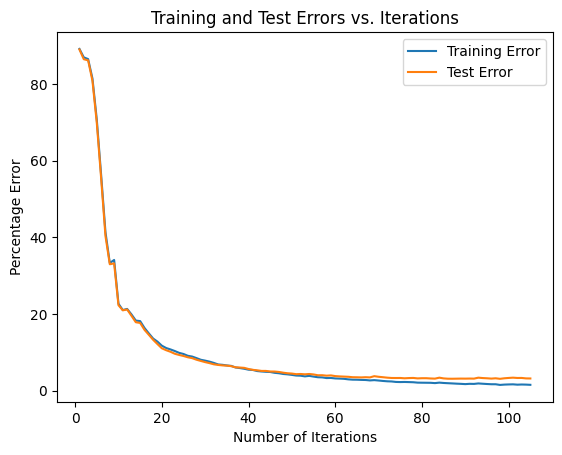

In [13]:
# Package all arguments into a tuple for optimisation function
myargs = (input_layer_size, hidden_layer_size, num_labels, X_train, y_train, lambda_reg, X_test, y_test)

# Minimise the cost function using the L-BFGS-B optimisation algorithm
results = minimize(neural_network, x0=initial_nn_params, args=myargs, options={'disp': True, 'maxiter': maxiter}, method='L-BFGS-B', jac=True)
print(results)

# Plot the training and test errors
plt.plot(iterations, train_errors, label='Training Error')
plt.plot(iterations, test_errors, label='Test Error')
plt.xlabel('Number of Iterations')
plt.ylabel('Percentage Error')
plt.title('Training and Test Errors vs. Iterations')
plt.legend()
plt.show()

`Objective / Cost function`
| Variable | Definition                                                                     |
| -------- | -------                                                                        |
| N        | total number of variables (parameters, weights)                                |
| M        | number of corrections (updates) stored in memory by the algorithm              |
| X0       | none of the variables are at their bounds                                      |
| f        | current value of cost function                                                 |
| proj g   | norm of projected gradient (how close optimisation is to a stationary point)   |
| success  | whether optimisation converged or not (did not)                                |
| fun      | value of cost function @ final params                                          |
| x        | final values of params (weights)                                               |
| nit      | number of iterations performed                                                 |
| jac      | gradient of cost function @ final params                                       |
| nfev     | # times cost function was evaluated                                            |
| njev     | # times gradient was evaluated                                                 |
| hess_inv | inverse of the approx Hessian matrix @ final point (helps understand curvature)|

In [14]:
# Extract the optimised weights (trained Theta)
nn_params = results["x"]
print("Optimised weights: \n", nn_params, "\n", nn_params.shape)

Optimised weights: 
 [-0.09112507 -0.07004774  0.05365012 ... -2.5326524  -2.76564081
  2.43783505] 
 (79510,)


In [15]:
# Split weights back into Theta1 (100 x 785) and Theta2 (10 x 101)
Theta1 = np.reshape(nn_params[:(hidden_layer_size * (input_layer_size + 1))], (hidden_layer_size, (input_layer_size + 1)))
Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))
print(Theta1.shape, Theta2.shape)

# Save Thetas in .txt files: (100 x 785) and (10 x 101)
np.savetxt('Theta1.txt', Theta1, delimiter=' ') 
np.savetxt('Theta2.txt', Theta2, delimiter=' ')

(100, 785) (10, 101)


In [16]:
# Function to count misclassifications and calculate accuracy
def count_misclassifications(y_true, y_pred, num_labels=10):
    # Initialize a dictionary to store the count of misclassifications for each digit
    misclassifications = {i: 0 for i in range(num_labels)}
    
    # Iterate through all the true labels and predictions
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            misclassifications[true_label] += 1
    
    # Calculate the total number of misclassifications
    total_misclassifications = sum(misclassifications.values())
    
    return misclassifications, total_misclassifications

# Initialize the table
table_train = PrettyTable()
table_train.field_names = ["Digit", "Misclassifications", "Total", "Accuracy (%)"]

# Predict and count misclassifications in the training set
pred_train = predict(Theta1, Theta2, X_train)
misclassifications_train, total_misclassifications_train = count_misclassifications(y_train, pred_train)

# Add rows for each digit
for digit, count in misclassifications_train.items():
    total_digit = len(y_train[y_train == digit])
    accuracy = 100 * (total_digit - count) / total_digit
    table_train.add_row([digit, count, total_digit, f"{accuracy:.2f}"])

# Add the total row
total_train = len(y_train)
overall_accuracy_train = 100 * (total_train - total_misclassifications_train) / total_train
table_train.add_row(["TOTAL", total_misclassifications_train, total_train, f"{overall_accuracy_train:.2f}"])

# Print the table for training set
print("Training Set Statistics:")
print(table_train)

# Repeat for the test set
table_test = PrettyTable()
table_test.field_names = ["Digit", "Misclassifications", "Total", "Accuracy (%)"]

pred_test = predict(Theta1, Theta2, X_test)
misclassifications_test, total_misclassifications_test = count_misclassifications(y_test, pred_test)

for digit, count in misclassifications_test.items():
    total_digit = len(y_test[y_test == digit])
    accuracy = 100 * (total_digit - count) / total_digit
    table_test.add_row([digit, count, total_digit, f"{accuracy:.2f}"])

total_test = len(y_test)
overall_accuracy_test = 100 * (total_test - total_misclassifications_test) / total_test
table_test.add_row(["TOTAL", total_misclassifications_test, total_test, f"{overall_accuracy_test:.2f}"])

print("\nTest Set Statistics:")
print(table_test)


Training Set Statistics:
+-------+--------------------+-------+--------------+
| Digit | Misclassifications | Total | Accuracy (%) |
+-------+--------------------+-------+--------------+
|   0   |         11         |  5923 |    99.81     |
|   1   |         28         |  6742 |    99.58     |
|   2   |         42         |  5958 |    99.30     |
|   3   |         72         |  6131 |    98.83     |
|   4   |         39         |  5842 |    99.33     |
|   5   |         47         |  5421 |    99.13     |
|   6   |         19         |  5918 |    99.68     |
|   7   |         36         |  6265 |    99.43     |
|   8   |         45         |  5851 |    99.23     |
|   9   |         74         |  5949 |    98.76     |
| TOTAL |        413         | 60000 |    99.31     |
+-------+--------------------+-------+--------------+

Test Set Statistics:
+-------+--------------------+-------+--------------+
| Digit | Misclassifications | Total | Accuracy (%) |
+-------+--------------------+-----

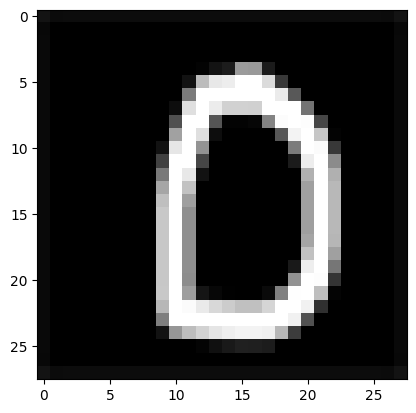

[0]


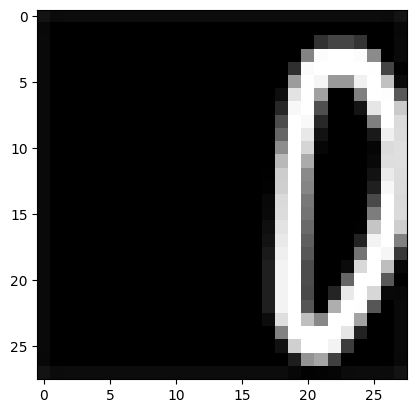

[2]


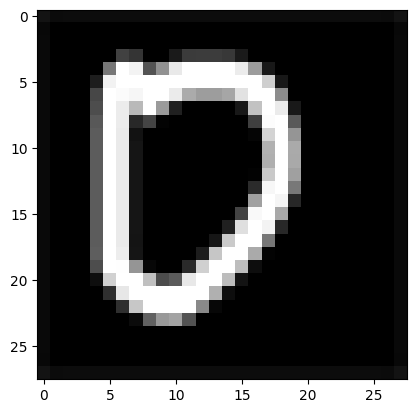

[3]


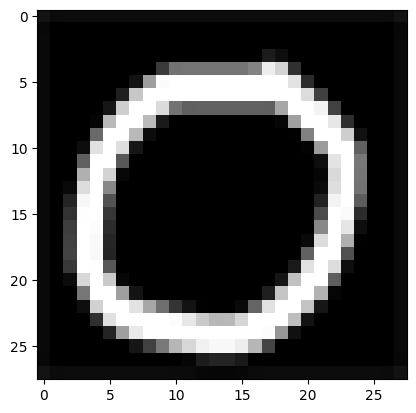

[0]


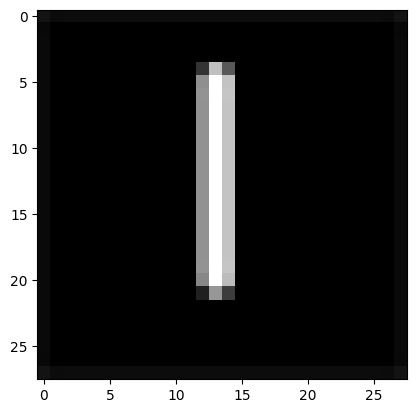

[1]


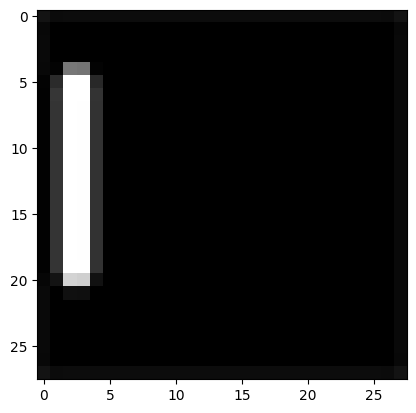

[7]


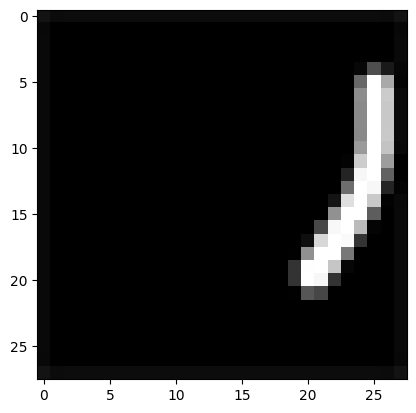

[5]


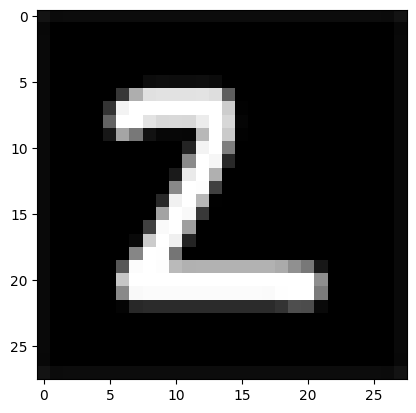

[2]


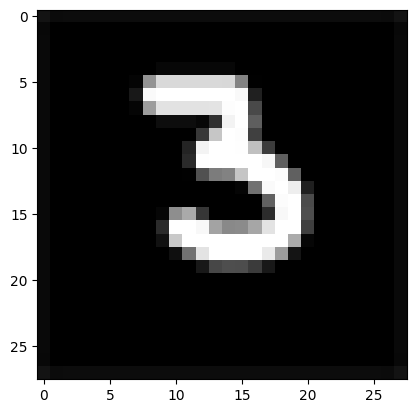

[7]


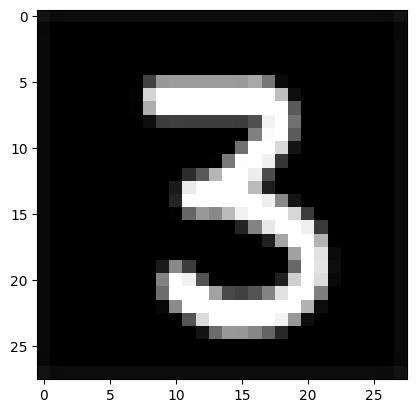

[3]


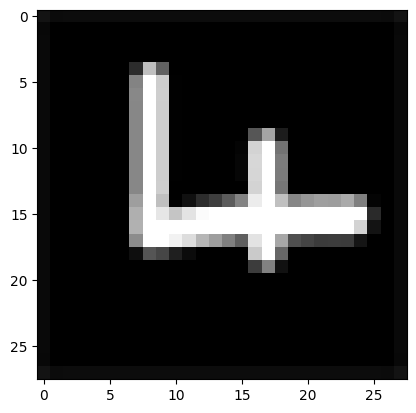

[4]


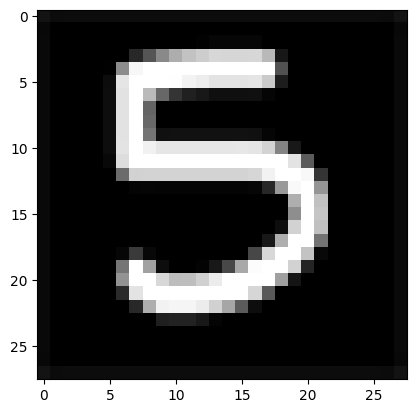

[3]


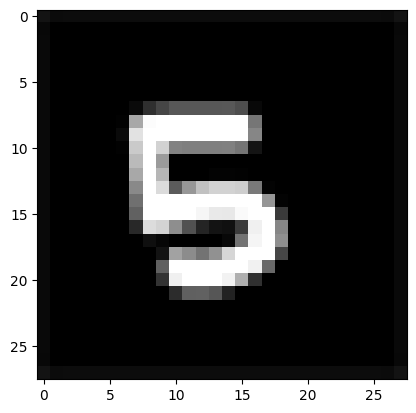

[2]


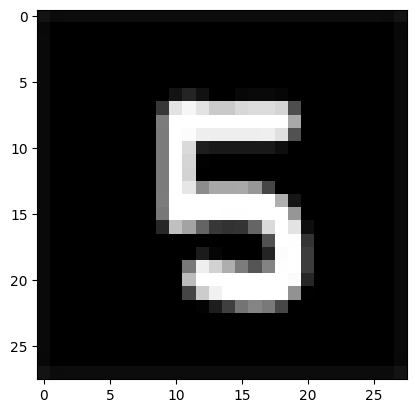

[5]


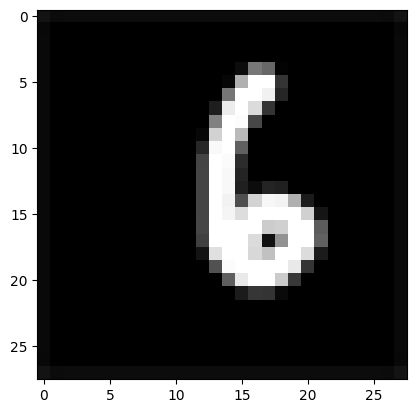

[7]


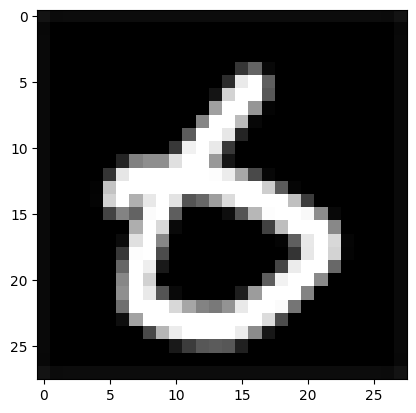

[6]


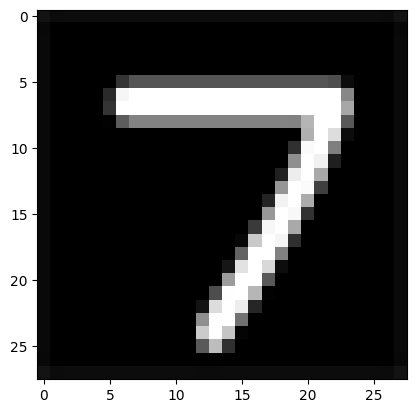

[7]


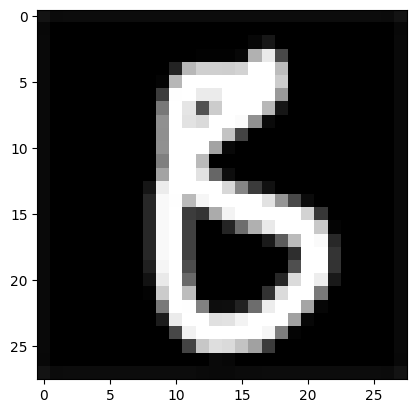

[8]


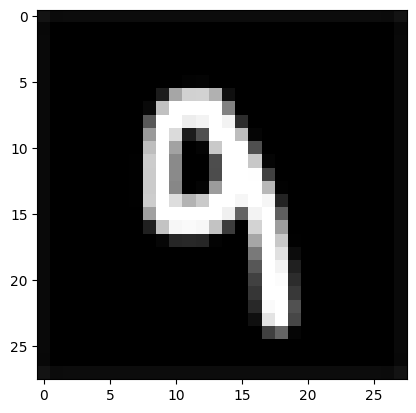

[9]


In [17]:
# Pop up widget to draw digit and output model prediction
window = Tk()
window.title("Handwritten digit recognition")
l1 = Label()

def Predictor():
    global l1

    # Get the widget (canvas) coordinates relative to the screen
    widget = cv
    x = widget.winfo_rootx()
    y = widget.winfo_rooty()
    x1 = x + widget.winfo_width()
    y1 = y + widget.winfo_height()

    # Capture the image from the canvas only using the exact coordinates
    img = ImageGrab.grab(bbox=(x, y, x1, y1)).resize((28, 28))

    # Convert to grayscale
    img = img.convert('L')

    # Display the captured image to verify
    plt.imshow(np.asarray(img), cmap='gray')
    plt.show()

    # Convert the image to a vector
    vec = np.asarray(img).flatten()

    # Load the pre-trained Thetas
    Theta1 = np.loadtxt('Theta1.txt')
    Theta2 = np.loadtxt('Theta2.txt')

    # Normalize the vector and make a prediction
    pred = predict(Theta1, Theta2, vec / 255)
    print(pred)

    # Display the prediction result
    l1 = Label(window, text="Digit = " + str(pred[0]), font=('Algerian', 20))
    l1.place(x=230, y=420)


lastx, lasty = None, None

# Clears the canvas
def clear_widget():
	global cv, l1
	cv.delete("all")
	l1.destroy()

# Activate canvas
def event_activation(event):
	global lastx, lasty
	cv.bind('<B1-Motion>', draw_lines)
	lastx, lasty = event.x, event.y

# To draw on canvas
def draw_lines(event):
	global lastx, lasty
	x, y = event.x, event.y
	cv.create_line((lastx, lasty, x, y), width=30, fill='white', capstyle=ROUND, smooth=TRUE, splinesteps=12)
	lastx, lasty = x, y

# Label
L1 = Label(window, text="Handwritten Digit Recoginition", font=('Algerian', 25), fg="blue")
L1.place(x=35, y=10)

# Button to clear canvas
b1 = Button(window, text="1. Clear Canvas", font=('Algerian', 15), bg="orange", fg="black", command=clear_widget)
b1.place(x=120, y=370)

# Button to predict digit drawn on canvas
b2 = Button(window, text="2. Prediction", font=('Algerian', 15), bg="white", fg="red", command=Predictor)
b2.place(x=320, y=370)

# Setting properties of canvas
cv = Canvas(window, width=350, height=290, bg='black')
cv.place(x=120, y=70)

cv.bind('<Button-1>', event_activation)
window.geometry("600x500")
window.mainloop()


## EVALUATION
-   MNIST dataset are 28x28, grayscaled, centred -> app needs for centred drawings otherwise it fails
-   MUST preprocess image by aligning it central before letting app guess the digit
-   When user clicks prediction
    1.  Extract screenshot of drawing
    2.  Crop around drawing
    3.  Find centre point (centre of mass)
    4.  Shift image to centre the digit
    5.  Run prediction algorithm on this centred image